In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, vstack
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In /home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

In [3]:
def lexeme_to_onehot(lexeme, idx_dict):
    one_hot = [0] * len(idx_dict)
    one_hot[idx_dict[lexeme]] = 1
    return one_hot

In [4]:
duolingo_dataset = pd.read_csv("./settles.acl16.learning_traces.13m.csv")

In [5]:
duolingo_dataset = duolingo_dataset[duolingo_dataset["learning_language"] == "en"]
duolingo_dataset.head(5)

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
87,1.0,1362082504,357,u:dwbJ,en,pt,1052c3ace653dbc8923eaa183bc02b88,definition/definition<n><sg>,17,17,2,2
88,1.0,1362082504,357,u:dwbJ,en,pt,9cba1b30f88bf3c047b22cffcaf88c12,surface/surface<n><sg>,19,19,3,3
89,1.0,1362082504,357,u:dwbJ,en,pt,961cd149f20f2571419b1412d849f19a,scale/scale<n><sg>,21,20,3,3
90,0.8,1362082504,357,u:dwbJ,en,pt,5cbb1249562e95794a4c4ae0e2d8ae26,temperature/temperature<n><sg>,44,36,5,4
91,1.0,1362082504,357,u:dwbJ,en,pt,2df65bdf80d10d2b78d62cb2e0a731d8,distance/distance<n><sg>,21,20,3,3


In [6]:
num_users = duolingo_dataset.user_id.unique().shape[0]
num_words = duolingo_dataset.lexeme_id.unique().shape[0]
print("For english, there are {} users and {} unique words being learned".format(num_users, num_words))

For english, there are 43805 users and 2983 unique words being learned


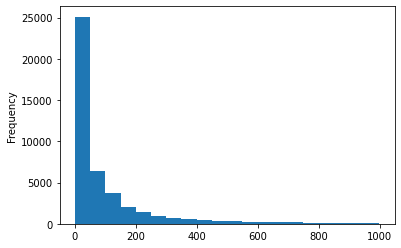

In [7]:
#Analysis on the number of sessions that each user took
count_per_user = duolingo_dataset.groupby("user_id").timestamp.count()
count_per_user_sub = count_per_user[count_per_user < 1000]
count_per_user_sub.plot.hist(bins = 20)

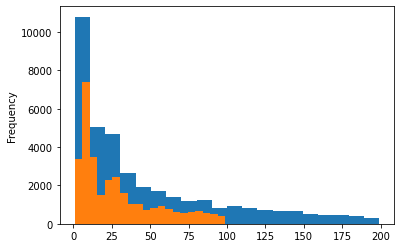

In [8]:
#There are some extreme value in the frequency count, so zoom it in
count_per_user_sub = count_per_user[count_per_user < 200]
count_per_user_sub.plot.hist(bins = 20)
count_per_user_sub = count_per_user[count_per_user < 100]
count_per_user_sub.plot.hist(bins = 20)

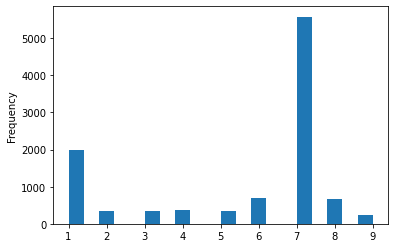

In [9]:
count_per_user_sub = count_per_user[count_per_user < 10]
count_per_user_sub.plot.hist(bins = 20)

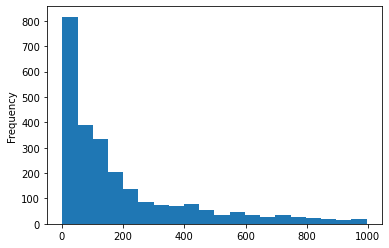

In [10]:
#Analysis on how many times that each word has been learned
count_per_string = duolingo_dataset.groupby("lexeme_string").timestamp.count()
count_per_string_sub = count_per_string[count_per_string < 1000]
count_per_string_sub.plot.hist(bins = 20)

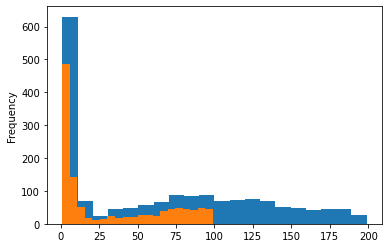

In [11]:
count_per_string_sub = count_per_string[count_per_string < 200]
count_per_string_sub.plot.hist(bins = 20)
count_per_string_sub = count_per_string[count_per_string < 100]
count_per_string_sub.plot.hist(bins = 20)

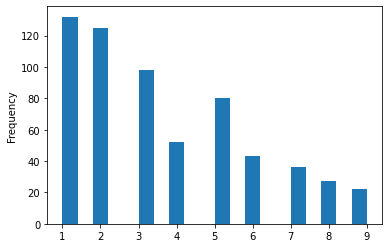

In [12]:
count_per_string_sub = count_per_string[count_per_string < 10]
count_per_string_sub.plot.hist(bins = 20)

# Data preprocessing

In [13]:
lexi_map = {}
for i, lexi in enumerate(duolingo_dataset.lexeme_string.unique()):
    lexi_map[lexi] = i

In [14]:
data, features, features_nolex = [], [], []
for _, instance in tqdm_notebook(duolingo_dataset.iterrows()):
    data.append([instance["p_recall"],
                 instance["user_id"]])
    features.append(
         coo_matrix(
             [
              [instance['delta']/(60*60*24),
                 instance["history_correct"],
                 instance["history_seen"]
              ] + 
                 lexeme_to_onehot(instance["lexeme_string"], lexi_map)
             ]
         )
    )
    
    features_nolex.append([instance['delta']/(60*60*24),
                 instance["history_correct"],
                 instance["history_seen"]
              ])
                

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [15]:
features = vstack(features)

In [16]:
y_regression = np.array([d[0] for d in data])
y_cls_05 = np.array([1 if d[0] >= 0.5 else 0 for d in data])
y_cls_06 = np.array([1 if d[0] >= 0.6 else 0 for d in data])
y_cls_08 = np.array([1 if d[0] >= 0.8 else 0 for d in data])

# Baseline

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
     features, y_regression, test_size=0.1, random_state=42)

In [27]:
k = 5
kfold_result = []
kf = KFold(n_splits=k)
for train_index, test_index in kf.split(X_train):
    X_val_train, y_val_train = X_train[train_index], y_train[train_index]
    X_val_test, y_val_test = X_train[test_index], y_train[test_index]
    
    lr = LinearRegression().fit(X_val_train, y_val_train)
    train_predict = lr.predict(X_val_train)
    train_predict = np.minimum(0.999, np.maximum(0.001, train_predict))
    val_predict = lr.predict(X_val_test)
    val_predict = np.minimum(0.999, np.maximum(0.001, val_predict))
    train_score = mean_absolute_error(train_predict, y_val_train)
    val_score = mean_absolute_error(val_predict, y_val_test)
    
    print("Train result: {}, Validation result: {}".format(train_score, val_score))
    kfold_result.append(val_score)

Train result: 0.16681465183985733, Validation result: 0.16679009781653456
Train result: 0.16674875980762735, Validation result: 0.16690892070502777
Train result: 0.16668251630965253, Validation result: 0.16703416036336874
Train result: 0.1668849801682103, Validation result: 0.1666215133649022
Train result: 0.16665852005563553, Validation result: 0.1670863055836762


In [40]:
# HLR by Duolingo
!python experiment.py settles.acl16.learning_traces.13m.csv

method = "hlr"
reading data...0...1000000...2000000...3000000...4000000...5000000...done!
|train| = 4513311
|test|  = 501480
test	73596989.4 (p=41968.8, h=73554968.7, l2=51.9)	mae(p)=0.128	cor(p)=0.033	mae(h)=115.408	cor(h)=0.215


In [18]:
#Pytorch one-layer neural network(soft logistic regression)
class SoftLR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftLR, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, X):
        return self.linear(X)

In [19]:
# Having trouble on turn the sparse matrix X_train and Y_train to 
# numpy array and then to torch tensor due to memory issue. 
# The error message below may be useful
X_tensor = torch.tensor(features_nolex).float()
y_tensor = torch.tensor(y_regression).float().reshape((-1, 1))

init_dataset = TensorDataset(X_tensor, y_tensor) 
# split train and val
lengths = [int(len(init_dataset)*0.9), len(init_dataset)-int(len(init_dataset)*0.9)] 
subset_train, subset_test = random_split(init_dataset, lengths) 

train_loader = DataLoader(subset_train, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(subset_test, batch_size=32, shuffle=False, num_workers=0)

In [20]:
weight_decay=0.15
epochs = 5
model = SoftLR(3,1)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)

for epoch in range(epochs):
    running_loss, batch_count = 0, 0
    for batch in tqdm_notebook(train_loader):
        X, y = batch
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_count += 1
        if batch_count % 19999 == 0:
            print("Epoch {}, loss {}".format(epoch+1, running_loss / 20000))
            running_loss = 0

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Epoch 1, loss 1.0454799183856696
Epoch 1, loss 0.1603858898836188
Epoch 1, loss 0.10527936238599941
Epoch 1, loss 0.10528195899231359
Epoch 1, loss 0.10506340120267123
Epoch 1, loss 0.10545318271815776
Epoch 1, loss 0.10496677389713004



Epoch 2, loss 0.10518910492165014
Epoch 2, loss 0.10506674792887644
Epoch 2, loss 0.10518367378152907
Epoch 2, loss 0.105141541977413
Epoch 2, loss 0.10412673500794917
Epoch 2, loss 0.10530293754255399
Epoch 2, loss 0.10518906231690198



Epoch 3, loss 0.10522003224911168
Epoch 3, loss 0.10528791308463552
Epoch 3, loss 0.10579413144709543
Epoch 3, loss 0.10500756171699613
Epoch 3, loss 0.10479261407861486
Epoch 3, loss 0.10490486250715331
Epoch 3, loss 0.10453413928374648



Epoch 4, loss 0.10545251732072793
Epoch 4, loss 0.1050709460190963
Epoch 4, loss 0.10494046980924904
Epoch 4, loss 0.10511518008895218
Epoch 4, loss 0.1050605773365125
Epoch 4, loss 0.10496908197142184
Epoch 4, loss 0.10469690207960083



Epoch 5, loss 0.10510929323174059
Epoch 5, loss 0.10527319513801485
Epoch 5, loss 0.10459844602225349
Epoch 5, loss 0.10468513046428561
Epoch 5, loss 0.10521765340361744
Epoch 5, loss 0.10542860514558852
Epoch 5, loss 0.1050461027953308



In [21]:
def evaluate(model, iterator):
    losses = 0
    loss_fn = nn.L1Loss()
    with torch.no_grad():
        for batch in tqdm_notebook(iterator):
            X, y = batch
            output = model(X)
            loss = loss_fn(y, output)
            losses += loss.item()
    return losses / len(iterator) 

In [22]:
evaluate(model, test_loader)

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0.10204131262828066

 # HLR in torch

In [54]:
class HLR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HLR, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, X):
        delta = X[:,0].reshape(-1,1)
        h = self.linear(X)
        h = torch.pow(h,2)
        return torch.pow(-delta/h, 2)

In [57]:
weight_decay=0.15
epochs = 5
model = HLR(3,1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)

for epoch in range(epochs):
    running_loss, batch_count = 0, 0
    for batch in tqdm_notebook(train_loader):
        X, y = batch
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_count += 1
        if batch_count % 19999 == 0:
            print("Epoch {}, loss {}".format(epoch+1, running_loss / 20000))
            running_loss = 0

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Epoch 1, loss 0.6803510714232922
Epoch 1, loss 0.6053136059910059
Epoch 1, loss 346.8165518438682
Epoch 1, loss 0.6036257855340839
Epoch 1, loss 0.6041398694217205
Epoch 1, loss 2.0707535118266324e+22
Epoch 1, loss 2.166299976161818e+16



Epoch 2, loss nan
Epoch 2, loss nan
Epoch 2, loss nan
Epoch 2, loss nan
Epoch 2, loss nan
Epoch 2, loss nan
Epoch 2, loss nan



KeyboardInterrupt: 

In [ ]:
evaluate(model, test_loader)